# Embedded ML - Lab 1.2: Model Compression

## Integrantes
Omar David Boneda

Luis Fernando Torres

In this lab you are asked to create a compressed verion of an ANNs model. You are not allowed to use ML libraries such as SciKit-learn, PyTorch or TensorFlow, but you are allowed to use standard libraries such as math, numpy and matplotlib if needed. You are given some code but you are expected to write some more and be able to explain and modify everything. This lab is essential for you to grasp the details of some of the most important techniques for compressing or making ML models more efficient: quantization and prunning.

### Learning outcomes


* Explain the basic concepts of compression in ANNs
* Apply range tuning and centering when doing quantization
* Calculate and analyze the impact of quantization and prunning on memory and computing

### Naive quantization
Quantization means reducing the precission of model parameters and mainly targets weights, since they represent the most volumne of memory and processing in ANNs.

Take the code from the last part of Lab 1.1 (MNIST model) and add methods to export and import weights to and from a binary file for which you have to define a format. Then, create two additional inference methods: FP16 and INT8. The FP16 method should treat all computations in the network as 16-bit floating-point. The INT8 method should work with 8-bit integers. In both cases, use the native datatype conversion methods.

Run the two quantized models and compare them with the baseline in terms of model size, accuracy and latency.

In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_input_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_hidden_output = np.zeros((1, self.output_size))

    def weights_flatten(self):
        #Se le hace un flatten a los pesos
        weights = np.concatenate((self.weights_input_hidden.flatten(), self.bias_input_hidden.flatten()))
        weights = np.concatenate((weights,self.weights_hidden_output.flatten()))
        weights = np.concatenate((weights,self.bias_hidden_output .flatten()))
        return weights

    def naive_quantized(self, x, cuantized):
        if cuantized == 0:
          #Cuantizado int 8 naive quantized
          x_int8 = np.floor(((2**7)/np.max(x))* x).astype(np.int8)
          weights_input_hidden_int8 = np.floor(((2**7)/np.max(self.weights_input_hidden))* self.weights_input_hidden).astype(np.int8)
          bias_input_hidden_int8 = np.floor(((2**7)/np.max(self.bias_input_hidden))* self.bias_input_hidden).astype(np.int8)
          weights_hidden_output_int8 = np.floor(((2**7)/np.max(self.weights_hidden_output))* self.weights_hidden_output).astype(np.int8)
          bias_hidden_output_int8 = np.floor(((2**7)/np.max(self.bias_hidden_output))* self.bias_hidden_output).astype(np.int8)
          name_int8 = 'model_weights_int8.npy'
          self.save_weights_binary(name_int8,weights_input_hidden_int8,bias_input_hidden_int8,weights_hidden_output_int8,bias_hidden_output_int8)
          return x_int8,weights_input_hidden_int8,bias_input_hidden_int8,weights_hidden_output_int8,bias_hidden_output_int8

        elif cuantized == 1:
          #Cuantizando int 8 tuning + centering
          scale= (2**8)/(np.max(x)-np.min(x))
          zeropoint=-np.floor(scale*np.min(x))-2**(8-1)
          x_int8_c = np.floor((scale*x)+zeropoint).astype(np.int8)
          weights_input_hidden_int8_c = np.floor((scale*weights_input_hidden)+zeropoint).astype(np.int8)
          bias_input_hidden_int8_c = np.floor((scale*bias_input_hidden)+zeropoint).astype(np.int8)
          weights_hidden_output_int8_c = np.floor((scale*weights_hidden_output)+zeropoint).astype(np.int8)
          bias_hidden_output_int8_c = np.floor((scale*bias_hidden_output)+zeropoint).astype(np.int8)
          name_int8_c = 'model_weights_int8_centering.npy'
          self.save_weights_binary(name_int8_c,weights_input_hidden_int8_c,bias_input_hidden_int8_c,weights_hidden_output_int8_c,bias_hidden_output_int8_c)
          return x_int8_c,weights_input_hidden_int8_c,bias_input_hidden_int8_c,weights_hidden_output_int8_c,bias_hidden_output_int8_c

        elif cuantized == 2:
          #Cuantizado fp16
          self.save_weights_binary('model_weights_fp16.npy', self.weights_input_hidden.astype(np.float16), self.bias_input_hidden.astype(np.float16), self.weights_hidden_output.astype(np.float16), self.bias_hidden_output.astype(np.float16))
          return  x.astype(np.float16),self.weights_input_hidden.astype(np.float16), self.bias_input_hidden.astype(np.float16), self.weights_hidden_output.astype(np.float16), self.bias_hidden_output.astype(np.float16)

        else:
          #sin cuantizar
          self.save_weights_binary('model_weights.npy', self.weights_input_hidden, self.bias_input_hidden, self.weights_hidden_output, self.bias_hidden_output)
          return  self.weights_input_hidden, self.bias_input_hidden, self.weights_hidden_output, self.bias_hidden_output

    def save_weights_binary(self,name, weights_input_hidden,bias_input_hidden,weights_hidden_output,bias_hidden_output):
      with open(name,'wb') as f:
        np.save(f,weights_input_hidden)
        np.save(f,bias_input_hidden)
        np.save(f,weights_hidden_output)
        np.save(f,bias_hidden_output)

    def load_weights_binary(self, name):
      with open(name, 'rb') as f:
        self.weights_input_hidden = np.load(f)
        self.bias_input_hidden = np.load(f)
        self.weights_hidden_output = np.load(f)
        self.bias_hidden_output = np.load(f)
      return self.weights_input_hidden, self.bias_input_hidden, self.weights_hidden_output, self.bias_hidden_output

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def ReLU(self,x):
        return np.abs(x * (x > 0))

    def dReLU(self,x):
        return np.abs(1. * (x > 0))

    def active_neuron(self, y):
        return np.argmax(y, axis=1)

    def forward(self, x):
        # Forward propagation through the network
        self.hidden_output = self.sigmoid(np.dot(x, self.weights_input_hidden) + self.bias_input_hidden)
        self.output = self.sigmoid(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.output

    def backward(self, x, y, output, learning_rate):
        # Backpropagation and weight updates
        self.error = y - output
        d_output = self.error * self.sigmoid_derivative(output)

        self.hidden_error = d_output.dot(self.weights_hidden_output.T)
        d_hidden = self.hidden_error * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += self.hidden_output.T.dot(d_output) * learning_rate
        self.bias_hidden_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += x.T.dot(d_hidden) * learning_rate
        self.bias_input_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    def train(self, x, y, epochs, learning_rate):
        error = 0
        for epoch in range(epochs):
            output = self.forward(x)
            self.backward(x, y, output, learning_rate)
            if epoch % 100 == 0:
                error = np.mean(np.square(y - output))
                print(f'Epoch {epoch}: Loss = {error:.4f}')

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the training and test data
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize the pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0


# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
#y_test = to_categorical(y_test, num_classes=10)

x_train = x_train[0:10000]
y_train = y_train[0:10000]

nn_mnist = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
nn_mnist.train(x_train, y_train, epochs=1200, learning_rate=0.0005)

Epoch 0: Loss = 0.2989
Epoch 100: Loss = 0.0988
Epoch 200: Loss = 0.0937
Epoch 300: Loss = 0.0881
Epoch 400: Loss = 0.0840
Epoch 500: Loss = 0.0781
Epoch 600: Loss = 0.0711
Epoch 700: Loss = 0.0680
Epoch 800: Loss = 0.0662
Epoch 900: Loss = 0.0645
Epoch 1000: Loss = 0.0571
Epoch 1100: Loss = 0.0465


In [2]:
#test model sin cuantificar
y_pred = nn_mnist.forward(x_test)
y_pred = nn_mnist.active_neuron(y_pred)

#Computation error
error = y_test - y_pred
print("Precision del modelo sin cuantificar",(np.count_nonzero(error==0)*100)/len(y_test))

Precision del modelo sin cuantificar 62.63


In [3]:
#Cargar modelo con pesos normales
weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output = nn_mnist.naive_quantized(x_test, 3)
print("Modelo sin cuantizar")
print(weights_input_hidden.shape, bias_input_hidden.shape, weights_hidden_output.shape, bias_hidden_output.shape)
print(weights_input_hidden[0,0:30])


Modelo sin cuantizar
(784, 80) (1, 80) (80, 10) (1, 10)
[-8.57963477e-02 -9.41172136e-01  7.35324649e-01  1.44057903e-01
  1.44977344e-01 -2.82324914e-01 -1.71723027e+00  1.00988430e+00
 -2.98478555e-01 -1.16592557e+00  5.69461375e-01 -2.09088737e-01
 -1.16697645e-01 -2.37744796e-01  7.26117721e-01 -2.67035312e-02
 -4.32253406e-02 -2.20114891e+00  2.02569824e-02  1.02187981e+00
 -1.54003509e+00  2.18368243e-03  3.42998167e-01  1.43530360e-01
  1.24316791e+00 -3.54641848e-01 -6.42608753e-01  8.56694167e-01
 -9.49031358e-01  1.69793687e+00]


In [4]:
#Cargar modelo cuantizado int8
x_test_int8, weights_input_hidden_int8, bias_input_hidden_int8, weights_hidden_output_int8, bias_hidden_output_int8 = nn_mnist.naive_quantized(x_test, 0)
nn_mnist_int8 = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
weights_input_hidden_int8,bias_input_hidden_int8,weights_hidden_output_int8,bias_hidden_output_int8 = nn_mnist_int8.load_weights_binary('model_weights_int8.npy')
print("Modelo cuantizado int8")
print(weights_input_hidden_int8.shape, bias_input_hidden_int8.shape, weights_hidden_output_int8.shape, bias_hidden_output_int8.shape)
print(weights_input_hidden_int8[0,0:30])
#Forward con int8
y_pred_int8 = nn_mnist_int8.forward(x_test_int8).astype(np.int8)
print("y_pred_int8: ",y_pred_int8.dtype)
y_pred_int8 = nn_mnist_int8.active_neuron(y_pred_int8).astype(np.int8)
print("y_pred_int8_active: ",y_pred_int8.dtype)
#Computation error
error = y_test.astype(np.int8) - y_pred_int8
#error = y_test - y_pred_int8
print("error int8: ",error.dtype)
print("Precision del modelo cuantificado int8",(np.count_nonzero(error==0)*100)/len(y_test))

Modelo cuantizado int8
(784, 80) (1, 80) (80, 10) (1, 10)
[ -3 -28  21   4   4  -9 -50  29  -9 -34  16  -7  -4  -7  20  -1  -2 -64
   0  29 -45   0   9   4  35 -11 -19  24 -28  48]
y_pred_int8:  int8
y_pred_int8_active:  int8
error int8:  int8
Precision del modelo cuantificado int8 10.06


<ipython-input-1-154c73705eae>:76: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [5]:
#Cargar modelo cuantizado float 16
x_test_fp16, weights_input_hidden_fp16, bias_input_hidden_fp16, weights_hidden_output_fp16, bias_hidden_output_fp16 = nn_mnist.naive_quantized(x_test, 2)
nn_mnist_fp16 = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
weights_input_hidden_fp16,bias_input_hidden_fp16,weights_hidden_output_fp16,bias_hidden_output_fp16 = nn_mnist_fp16.load_weights_binary('model_weights_fp16.npy')
print("Modelo cuantizado fp16")
print(weights_input_hidden_fp16.shape, bias_input_hidden_fp16.shape, weights_hidden_output_fp16.shape, bias_hidden_output_fp16.shape)
print(weights_input_hidden_fp16[0,0:30])
#Forward con fp16
y_pred_fp16 = nn_mnist_fp16.forward(x_test_fp16).astype(np.float16)
print("y_pred_fp16: ",y_pred_fp16.dtype)
y_pred_fp16 = nn_mnist_fp16.active_neuron(y_pred_fp16).astype(np.float16)
print("y_pred_fp16_active: ",y_pred_fp16.dtype)
#Computation error
error = y_test.astype(np.float16) - y_pred_fp16
#error = y_test - y_pred_fp16
print("error fp16: ",error.dtype)
print("Precision del modelo cuantificado float 16",(np.count_nonzero(error==0)*100)/len(y_test))

Modelo cuantizado fp16
(784, 80) (1, 80) (80, 10) (1, 10)
[-8.582e-02 -9.414e-01  7.354e-01  1.440e-01  1.450e-01 -2.822e-01
 -1.717e+00  1.010e+00 -2.986e-01 -1.166e+00  5.693e-01 -2.091e-01
 -1.167e-01 -2.378e-01  7.261e-01 -2.670e-02 -4.321e-02 -2.201e+00
  2.026e-02  1.021e+00 -1.540e+00  2.184e-03  3.430e-01  1.436e-01
  1.243e+00 -3.547e-01 -6.426e-01  8.569e-01 -9.492e-01  1.698e+00]
y_pred_fp16:  float16
y_pred_fp16_active:  float16
error fp16:  float16
Precision del modelo cuantificado float 16 62.64


<ipython-input-1-154c73705eae>:76: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### Range tuning and centering
For quantization to be effective, you should smartly choose the range of numbers you will code with the fewer bits available after quantization. To do so, you should evaluate the dynamic ranges of the variables to be quantized and map the values using that as the full range.

Make a histogram plot of the model weights in order to verify their range. Then write a function to quantize the weights stored in the exported binary file to INT8 and store the resulting weights in another file. Finally, run again the INT8 quantized inference with the newly computed weights and compare with the previous versions using the same metrics.

Promedio -0.0031045671110856744
Maximo: 4.438535142980115
Mínimo: -4.692199240760835


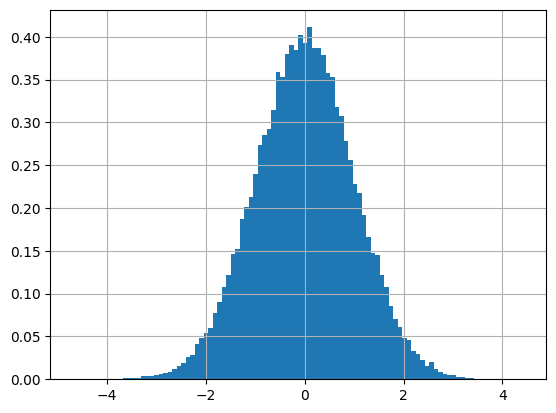

In [6]:
# histograma de pesos sin cuantificar
def plot_histogram(weights):
  print("Promedio",np.mean(weights))
  print("Maximo:",np.max(weights))
  print("Mínimo:",np.min(weights))

  # plot a histogram of all model weights
  #plt.xticks([i for i in range(-5,5)])
  plt.hist(weights,density=1,bins=100)
  plt.grid()
  plt.show

#Histograma
weights =nn_mnist.weights_flatten()
plot_histogram(weights)


In [7]:
#Cuantizar modelo int8 con centering
x_test_int8_c, weights_input_hidden_int8_c, bias_input_hidden_int8_c, weights_hidden_output_int8_c, bias_hidden_output_int8_c = nn_mnist.naive_quantized(x_test, 1)

#Cargar nuevo modelo con centering
nn_mnist_int8_c = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
weights_input_hidden_int8_c,bias_input_hidden_int8_c,weights_hidden_output_int8_c,bias_hidden_output_int8_c = nn_mnist_int8_c.load_weights_binary('model_weights_int8_centering.npy')

#Forward con int8 y cenetering
y_pred_int8_c = nn_mnist_int8_c.forward(x_test_int8_c).astype(np.int8)
print("y_pred_int8: ",y_pred_int8_c.dtype)
y_pred_int8_c = nn_mnist_int8_c.active_neuron(y_pred_int8_c).astype(np.int8)
print("y_pred_int8_active: ",y_pred_int8_c.dtype)

#Computation error
error = y_test.astype(np.int8) - y_pred_int8_c
print("error int8 centering: ",error.dtype)
print("Precision del modelo cuantificado int 8 con centering",(np.count_nonzero(error==0)*100)/len(y_test))

y_pred_int8:  int8
y_pred_int8_active:  int8
error int8 centering:  int8
Precision del modelo cuantificado int 8 con centering 11.09


<ipython-input-1-154c73705eae>:76: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Promedio -0.32936645181575225
Maximo: 127
Mínimo: -128


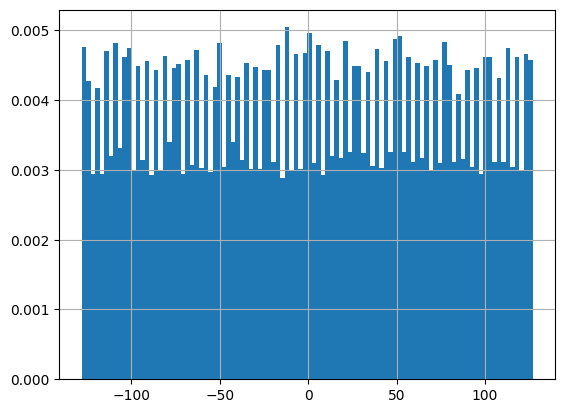

In [8]:
#histograma de pesos cuantificados a int8 y centering
weights =nn_mnist_int8_c.weights_flatten()
plot_histogram(weights)

### Prunning
Besides reducing precision for the network weights, we can also decide to eliminate network connections that do not contribute significantly to the model. This can be achieved by simply removing the connections whose weights are closest to zero.

In this part of the lab you are asked to generate three prunned versions of the original model by setting to zero some of the weights:


*   Set to zero the smallest 10% of weights
*   Set to zero the smallest 30% of weights
*   Set to zero the smallest 50% of weights

Report the accuracy for each model against the estimated memory savings.



In [9]:
def prune_model(weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, percentage):

    # Prune the input-to-hidden weights matrix
    weights_input_hidden_prunned = prune_matrix(weights_input_hidden, percentage)
    print("weights_input_hidden_prunned shape:", weights_input_hidden_prunned.shape)

    # Prune the input-to-hidden bias vector
    bias_input_hidden_prunned = prune_vector(bias_input_hidden, percentage)
    print("bias_input_hidden_prunned shape:", bias_input_hidden_prunned.shape)

    # Prune the hidden-to-output weights matrix
    weights_hidden_output_prunned = prune_matrix(weights_hidden_output, percentage)
    print("weights_hidden_output_prunned shape:", weights_hidden_output_prunned.shape)

    # Prune the hidden-to-output bias vector
    bias_hidden_output_prunned = prune_vector(bias_hidden_output, percentage)
    print("bias_hidden_output_prunned shape:", bias_hidden_output_prunned.shape)

    return weights_input_hidden_prunned, bias_input_hidden_prunned, weights_hidden_output_prunned, bias_hidden_output_prunned

def prune_matrix(matrix, percentage):
    # Calculate the number of elements to prune
    num_elements_to_prune = int(matrix.size * percentage / 100)

    # Find the indices of the smallest values
    indices = np.argpartition(np.abs(matrix.flatten()), num_elements_to_prune)[:num_elements_to_prune]

    # Convert indices to (x, y) coordinates
    coordinates = [(index // matrix.shape[0], index % matrix.shape[1]) for index in indices]

    # Set the smallest values to zero
    for x, y in coordinates:
        matrix[x, y] = 0

    return matrix

def prune_vector(vector, percentage):
    # Calculate the number of elements to prune
    num_elements_to_prune = int(vector.size * percentage / 100)

    # Find the indices of the smallest values
    indices = np.argpartition(np.abs(vector), num_elements_to_prune)[:num_elements_to_prune]

    # Set the smallest values to zero
    for index in indices:
        vector[index] = 0

    return vector

In [10]:
# Pruned model with 10%
weights_input_hidden_p10, bias_input_hidden_p10, weights_hidden_output_p10, bias_hidden_output_p10 = prune_model(weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, 0.1)

#Crear un nuevo objeto
nn_mnist_p10 = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
nn_mnist_p10.weights_input_hidden = weights_input_hidden_p10
nn_mnist_p10.bias_input_hidden_p10 = bias_input_hidden_p10
nn_mnist_p10.weights_hidden_output_p10 = weights_hidden_output_p10
nn_mnist_p10.bias_hidden_output_p10= bias_hidden_output_p10

print(weights_input_hidden_p10.shape, bias_input_hidden_p10.shape, weights_hidden_output_p10.shape, bias_hidden_output_p10.shape)
#test model
y_pred_p10= nn_mnist_p10.forward(x_test)
y_pred_p10 = nn_mnist_p10.active_neuron(y_pred_p10)

#Computation error
error = y_test - y_pred_p10
print("Precision del modelo sin cuantificar y prunning 10%",(np.count_nonzero(error==0)*100)/len(y_test))


weights_input_hidden_prunned shape: (784, 80)
bias_input_hidden_prunned shape: (1, 80)
weights_hidden_output_prunned shape: (80, 10)
bias_hidden_output_prunned shape: (1, 10)
(784, 80) (1, 80) (80, 10) (1, 10)
Precision del modelo sin cuantificar y prunning 10% 11.35


In [11]:
# Pruned model with 30%
weights_input_hidden_p30, bias_input_hidden_p30, weights_hidden_output_p30, bias_hidden_output_p30 = prune_model(weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, 0.3)

#Crear un nuevo objeto
nn_mnist_p30 = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
nn_mnist_p30.weights_input_hidden = weights_input_hidden_p30
nn_mnist_p30.bias_input_hidden_p30 = bias_input_hidden_p30
nn_mnist_p30.weights_hidden_output_p30 = weights_hidden_output_p30
nn_mnist_p30.bias_hidden_output_p30 = bias_hidden_output_p30

print(weights_input_hidden_p30.shape, bias_input_hidden_p30.shape, weights_hidden_output_p30.shape, bias_hidden_output_p30.shape)
#test model
y_pred_p30 = nn_mnist_p30.forward(x_test)
y_pred_p30 = nn_mnist_p30.active_neuron(y_pred_p30)

#Computation error
error = y_test - y_pred_p30
print("Precision del modelo sin cuantificar y prunning 30%",(np.count_nonzero(error==0)*100)/len(y_test))

weights_input_hidden_prunned shape: (784, 80)
bias_input_hidden_prunned shape: (1, 80)
weights_hidden_output_prunned shape: (80, 10)
bias_hidden_output_prunned shape: (1, 10)
(784, 80) (1, 80) (80, 10) (1, 10)
Precision del modelo sin cuantificar y prunning 30% 10.3


In [12]:
# Pruned model with 50%
weights_input_hidden_p50, bias_input_hidden_p50, weights_hidden_output_p50, bias_hidden_output_p50= prune_model(weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, 0.5)

#Crear un nuevo objeto
nn_mnist_p50 = NeuralNetwork(input_size=784, hidden_size=80, output_size=10)
nn_mnist_p50.weights_input_hidden = weights_input_hidden_p50
nn_mnist_p50.bias_input_hidden_p50 = bias_input_hidden_p50
nn_mnist_p50.weights_hidden_output_p50 = weights_hidden_output_p50
nn_mnist_p50.bias_hidden_output_p50 = bias_hidden_output_p50

#test model
y_pred_p50 = nn_mnist_p50.forward(x_test)
y_pred_p50 = nn_mnist_p50.active_neuron(y_pred_p50)

#Computation error
error = y_test - y_pred_p50
print("Precision del modelo sin cuantificar y prunning 50%",(np.count_nonzero(error==0)*100)/len(y_test))

weights_input_hidden_prunned shape: (784, 80)
bias_input_hidden_prunned shape: (1, 80)
weights_hidden_output_prunned shape: (80, 10)
bias_hidden_output_prunned shape: (1, 10)
Precision del modelo sin cuantificar y prunning 50% 10.29


## Analysis

Discuss the following questions based on the lab experiments and the theory studied:


*   How is it important to store the weights in binary format?

The main reason for using binary format is independent of the machine or hardware architecture, so it can be read and written in a computer processor as in a microcontroller. Furthermore, using other formats with json, txt or csv consume more memory space and resources since they add metadata to the data that carries extra information about its structure and organization.


*   How much reduction in model memory requirements can be achieved by each of the versions obtained?

1. int8 model: a memory consumption of 64KB was achieved
2. int8 with centering model: a memory consumption of 64KB was achieved
3. float16 model: memory consumption of 128KB was achieved
4. original unquantized model: memory consumption is 509KB



|                     | *size memory* | *mean accuracy* |
|:-------------------:|:---------------------:|:----------------------:|
|      *Float 64*      |        509.4 kB       |           78%          |
|      *Float 16*      |        127.7 kB       |           78%          |
|   *Naive Int 8*   |        64.1 kB        |           10%          |
| *Centering Int 8* |        64.1 kB        |           11%          |

Therefore, the reduction in model memory requirements achieved by each version compared to the original unquantized model is as follows:

INT8 Model: 445KB
INT8 with Centering Model: 445 KB
Float16 model: 381 KB
These reductions in memory consumption highlight the effectiveness of quantization techniques, such as using INT8 and float16 data types for weights, resulting in significant memory savings but at the same time reducing model accuracy.


*   What are the posible computational advantages of the obtained models and how do they depend on the hardware?

The computational advantages of the models obtained, particularly through techniques such as quantization and pruning, are essential to improve performance and efficiency in embedded systems. By employing lower precision data types and eliminating redundant connections, quantized and pruned models significantly reduce computational complexity and memory requirements, enabling faster inference times, lower power consumption, and optimal resource utilization. . These advantages are especially critical in embedded systems, where hardware resources are often limited and real-time processing is essential. Optimizing models for embedded systems involves striking a balance between computational efficiency, memory limitations, and real-time performance requirements to achieve optimal results.


## Conclusions


* The pruning method may generate inconsistent results, since if random weights are set to zero, i.e., the connection is randomly "turned off", there may be weights with a high level of relevance. If these are removed, the performance of the model may decrease significantly. To avoid this, a criterion must be established to remove the weights that contribute the least to the model, thus reducing the computational cost without affecting accuracy.

* Compression of AI models and quantization of their weights offer significant computational advantages, such as reduced memory footprint and faster inference times. These advantages depend on the hardware used and are especially important for embedded devices with limited memory resources and computing power. However, it is important to keep in mind that quantization can affect the accuracy of the model, so it is necessary to find a balance between efficiency and performance.